In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200) # Display all columns

In [2]:
df = pd.read_parquet("../data/processed/churn_prediction_dataset.parquet")
df.head()

,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_anual,mcomisiones,mactivos_margen,mpasivos_margen,cant_total_prod,tpaquete1,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,mdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cfondos_comunes_inversion,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolares,ctitulos,mtitulos,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,mbonos_corporativos,mmonedas_extranjeras,minversiones_otras,cplan_sueldo,mplan_sueldo,mplan_sueldo_manual,cplan_sueldo_transaccion,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,ccambio_monedas,ccambio_monedas_compra,mcambio_monedas_compra,ccambio_monedas_venta,mcambio_monedas_venta,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,thomebanking,chomebanking_transacciones,cautoservicio,cautoservicio_transacciones,tmovimientos_ultimos90dias,visa_marca_atraso,visa_mfinanciacion_limite,visa_msaldototal,visa_msaldopesos,visa_msaldodolares,visa_mconsumospesos,visa_mconsumosdolares,visa_mlimitecompra,visa_mpagado,visa_mpagospesos,visa_mpagosdolares,visa_mconsumototal,visa_cconsumos,visa_mpagominimo,clase_binaria,visa_tenure_days,tcuentas_2,visa_cuenta_estado_11.0,visa_cuenta_estado_12.0,visa_cuenta_estado_19.0
0,0,1,44,72,3296.69,14455.27,579.66,910.65,1411.60,11,1,0,0,0,0,0,0,0,0,1.17,-460.04,2,2574.00,1,17,19451.75,1,18,17091.34,3,73704.79,0,0.0,0.0,0,0.0,0.0,0,0.00,0,1,0,0,0,0,0,1,56580.03,0.0,0,1,68.94,0,0.0,0,0.00,0,0.0,0.00,14,579.66,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,116,0.0,63180.0,29994.31,32262.86,2830.47,14555.47,59.47,70200.0,0.0,-19632.60,0.00,14555.47,13.0,3837.6,0,4203,False,False,False,False
1,0,0,78,159,1032.18,10141.18,790.58,71.21,135.29,6,1,0,0,0,0,0,0,0,0,1.17,6301.72,0,0.00,1,1,174.33,1,0,0.00,0,0.00,0,0.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,0,0.00,0,0.0,833.97,4,790.58,0,0,0.0,0,0.0,0,0.0,1,351.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,1,0,0,17,0.0,63180.0,182.45,213.46,0.00,-11.55,4.22,70200.0,0.0,-2976.51,62.78,-11.55,2.0,35.1,0,6859,False,False,False,False
2,0,1,64,299,-52.34,4752.64,236.08,-422.18,175.66,7,1,0,0,0,0,0,0,0,0,1.17,45.63,0,0.00,1,8,11670.93,1,0,0.00,0,0.00,0,0.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,0,0.00,0,0.0,0.00,6,236.08,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0,0,0,10,0.0,176904.0,10367.71,12130.22,0.00,6788.67,0.00,196560.0,0.0,-12753.00,0.00,6788.67,4.0,1977.3,0,10314,False,False,False,False
3,0,1,48,282,485.91,10676.87,1280.47,-1275.18,596.07,8,1,0,0,0,0,0,0,0,0,1.17,5429.85,4,4103.69,1,9,9840.21,1,14,12383.23,0,0.00,0,0.0,0.0,0,0.0,0.0,3,10509.33,0,0,0,0,0,0,0,0,0.00,0.0,0,4,5303.31,0,0.0,0,0.00,2,2460.0,833.97,18,1280.47,0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,78,0,0,85,0.0,176904.0,6754.10,7433.72,468.57,2946.70,10.51,196560.0,0.0,-3685.76,0.00,2946.70,5.0,573.3,0,3578,False,False,False,False
4,0,1,45,171,5878.27,24298.75,64.38,22.11,4947.03,9,1,0,0,0,0,0,0,0,0,1.17,563006.87,10,4313.45,1,2,1496.03,1,0,0.00,0,0.00,1,351000.0,0.0,0,0.0,0.0,0,0.00,0,0,0,0,0,0,0,0,0.00,0.0,0,0,0.00,0,0.0,7,2171.89,1,339.3,0.00,12,64.38,0,0,0.0,0,0.0,0,0.0,2,16160.54,5,4797.0

# Logistic Regresion

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report

# Features and target
X = df.drop(columns=["clase_binaria"])  # Exclude the target column
y = df["clase_binaria"]

# Define the Logistic Regression model with class balancing
log_reg_model = LogisticRegression(class_weight='balanced', random_state=12, max_iter=1000)

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Perform stratified cross-validation with AUC scoring
cv_auc_scores = cross_val_score(log_reg_model, X, y, cv=skf, scoring='roc_auc')  # Using AUC as the metric

# Perform stratified cross-validation with Accuracy scoring
cv_accuracy_scores = cross_val_score(log_reg_model, X, y, cv=skf, scoring='accuracy')  # Using Accuracy as the metric

# Print Cross-Validation AUC Scores
print("Cross-Validation AUC Scores:", cv_auc_scores)

# Print Cross-Validation Accuracy Scores
print("Cross-Validation Accuracy Scores:", cv_accuracy_scores)

# Calculate and print the Mean AUC Score
print("Mean AUC Score:", cv_auc_scores.mean())

# Calculate and print the Mean Accuracy Score
print("Mean Accuracy Score:", cv_accuracy_scores.mean())

# Calculate and print the validation errors (1 - AUC score)
cv_auc_errors = 1 - cv_auc_scores
print("Validation Errors (AUC):", cv_auc_errors)
print("Mean Validation Error (AUC):", cv_auc_errors.mean())

# Calculate and print the validation errors (1 - accuracy score)
cv_accuracy_errors = 1 - cv_accuracy_scores
print("Validation Errors (Accuracy):", cv_accuracy_errors)
print("Mean Validation Error (Accuracy):", cv_accuracy_errors.mean())

# Fit the Logistic Regression model on the entire dataset (optional, for evaluation purposes)
log_reg_model.fit(X, y)
y_pred = log_reg_model.predict(X)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["No Churn", "Churn"]))


/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

Cross-Validation AUC Scores: [0.86164414 0.86449538 0.84270938 0.85252056 0.8710361 ]
Cross-Validation Accuracy Scores: [0.77263478 0.77156482 0.76864901 0.77031952 0.76716073]
Mean AUC Score: 0.8584811146367398
Mean Accuracy Score: 0.7700657718699065
Validation Errors (AUC): [0.13835586 0.13550462 0.15729062 0.14747944 0.1289639 ]
Mean Validation Error (AUC): 0.14151888536326018
Validation Errors (Accuracy): [0.22736522 0.22843518 0.23135099 0.22968048 0.23283927]
Mean Validation Error (Accuracy): 0.22993422813009357

Classification Report:
              precision    recall  f1-score   support

    No Churn       1.00      0.77      0.87    163292
       Churn       0.03      0.85      0.06      1329

    accuracy                           0.77    164621
   macro avg       0.51      0.81      0.46    164621
weighted avg       0.99      0.77      0.86    164621



/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# Features and target
X = df.drop(columns=["clase_binaria"])  # Exclude the target column
y = df["clase_binaria"]

# Define the Random Forest model with class balancing
rf_model = RandomForestClassifier(class_weight='balanced', random_state=12, n_estimators=100)

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Perform stratified cross-validation with AUC scoring
cv_auc_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='roc_auc')  # Using AUC as the metric

# Perform stratified cross-validation with Accuracy scoring
cv_accuracy_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='accuracy')  # Using Accuracy as the metric

# Print Cross-Validation AUC Scores
print("Cross-Validation AUC Scores:", cv_auc_scores)

# Print Cross-Validation Accuracy Scores
print("Cross-Validation Accuracy Scores:", cv_accuracy_scores)

# Calculate and print the Mean AUC Score
print("Mean AUC Score:", cv_auc_scores.mean())

# Calculate and print the Mean Accuracy Score
print("Mean Accuracy Score:", cv_accuracy_scores.mean())

# Calculate and print the validation errors (1 - AUC score)
cv_auc_errors = 1 - cv_auc_scores
print("Validation Errors (AUC):", cv_auc_errors)
print("Mean Validation Error (AUC):", cv_auc_errors.mean())

# Calculate and print the validation errors (1 - accuracy score)
cv_accuracy_errors = 1 - cv_accuracy_scores
print("Validation Errors (Accuracy):", cv_accuracy_errors)
print("Mean Validation Error (Accuracy):", cv_accuracy_errors.mean())

# Fit the Random Forest model on the entire dataset (optional, for evaluation purposes)
rf_model.fit(X, y)
y_pred = rf_model.predict(X)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["No Churn", "Churn"]))


Cross-Validation AUC Scores: [0.89676429 0.90613798 0.86791944 0.87287873 0.88408228]
Cross-Validation Accuracy Scores: [0.9932574  0.9940469  0.99374317 0.99374317 0.99368242]
Mean AUC Score: 0.8855565445023066
Mean Accuracy Score: 0.9936946102696927
Validation Errors (AUC): [0.10323571 0.09386202 0.13208056 0.12712127 0.11591772]
Mean Validation Error (AUC): 0.11444345549769337
Validation Errors (Accuracy): [0.0067426  0.0059531  0.00625683 0.00625683 0.00631758]
Mean Validation Error (Accuracy): 0.0063053897303073205

Classification Report:
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00    163292
       Churn       1.00      1.00      1.00      1329

    accuracy                           1.00    164621
   macro avg       1.00      1.00      1.00    164621
weighted avg       1.00      1.00      1.00    164621



# XGBoost

In [3]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score

# Features and target
X = df.drop(columns=["clase_binaria"])  # Exclude the target column
y = df["clase_binaria"]

# Define the XGBoost model with class balancing
xgb_model = xgb.XGBClassifier(scale_pos_weight=1, random_state=12, n_estimators=100)

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Perform stratified cross-validation with AUC scoring
cv_auc_scores = cross_val_score(xgb_model, X, y, cv=skf, scoring='roc_auc')  # Using AUC as the metric

# Perform stratified cross-validation with Accuracy scoring
cv_accuracy_scores = cross_val_score(xgb_model, X, y, cv=skf, scoring='accuracy')  # Using Accuracy as the metric

# Print Cross-Validation AUC Scores
print("Cross-Validation AUC Scores:", cv_auc_scores)

# Print Cross-Validation Accuracy Scores
print("Cross-Validation Accuracy Scores:", cv_accuracy_scores)

# Calculate and print the Mean AUC Score
print("Mean AUC Score:", cv_auc_scores.mean())

# Calculate and print the Mean Accuracy Score
print("Mean Accuracy Score:", cv_accuracy_scores.mean())

# Calculate and print the validation errors (1 - AUC score)
cv_auc_errors = 1 - cv_auc_scores
print("Validation Errors (AUC):", cv_auc_errors)
print("Mean Validation Error (AUC):", cv_auc_errors.mean())

# Calculate and print the validation errors (1 - accuracy score)
cv_accuracy_errors = 1 - cv_accuracy_scores
print("Validation Errors (Accuracy):", cv_accuracy_errors)
print("Mean Validation Error (Accuracy):", cv_accuracy_errors.mean())

# Fit the XGBoost model on the entire dataset (optional, for evaluation purposes)
xgb_model.fit(X, y)
y_pred = xgb_model.predict(X)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["No Churn", "Churn"]))


Cross-Validation AUC Scores: [0.93728772 0.94780681 0.92716024 0.93602409 0.92976706]
Cross-Validation Accuracy Scores: [0.99362187 0.99432025 0.9940469  0.99422913 0.99407727]
Mean AUC Score: 0.9356091861910848
Mean Accuracy Score: 0.9940590838180787
Validation Errors (AUC): [0.06271228 0.05219319 0.07283976 0.06397591 0.07023294]
Mean Validation Error (AUC): 0.06439081380891525
Validation Errors (Accuracy): [0.00637813 0.00567975 0.0059531  0.00577087 0.00592273]
Mean Validation Error (Accuracy): 0.005940916181921274

Classification Report:
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00    163292
       Churn       0.99      0.65      0.79      1329

    accuracy                           1.00    164621
   macro avg       1.00      0.83      0.89    164621
weighted avg       1.00      1.00      1.00    164621



In [7]:
# Temporarily display the full list of columns
pd.set_option('display.max_rows', None)  # Show all rows
print(X.dtypes)

# Reset to default after viewing
# pd.reset_option('display.max_rows')

cliente_vip                             int64
internet                                int64
cliente_edad                            int64
cliente_antiguedad                      int64
mrentabilidad                         float64
mrentabilidad_anual                   float64
mcomisiones                           float64
mactivos_margen                       float64
mpasivos_margen                       float64
cant_total_prod                         int64
tpaquete1                               int64
tpaquete2                               int64
tpaquete3                               int64
tpaquete4                               int64
tpaquete5                               int64
tpaquete6                               int64
tpaquete7                               int64
tpaquete8                               int64
tpaquete9                               int64
mdescubierto_preacordado              float64
mcuentas_saldo                        float64
ctarjeta_debito_transacciones     

In [ ]:
# Boolean columns (bool) need to be converted to integers for SHAP to process them:
X = X.astype({col: 'int64' for col in X.select_dtypes(include=['bool']).columns})


In [9]:
import shap

# Create the SHAP explainer using the trained XGBoost model
explainer = shap.Explainer(xgb_model, X)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X)


100%|===================| 164383/164621 [05:42<00:00]        

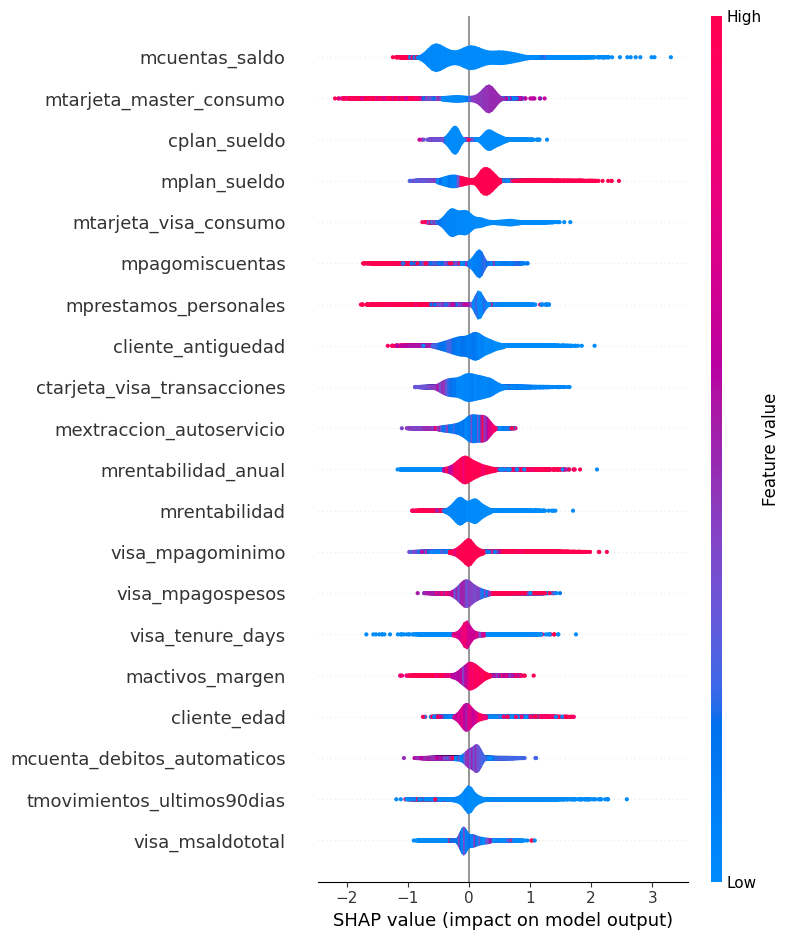

In [10]:
# Plot the summary plot (violin-style)
shap.summary_plot(shap_values, X, plot_type="violin")

I'll be identifying one true positive, one true negative, one false positive, and one false negative, by compareing the predictions of the model (y_pred) against the true labels (y). I'll use these values to display them in a waterfall plot.

In [11]:
y_prob = xgb_model.predict_proba(X)[:, 1]  # Probability of the positive class
y_pred = xgb_model.predict(X)             # Predicted class labels


In [60]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

# Print the confusion matrix with labels
print("Confusion Matrix:")
print(f"                Predicted No   Predicted Yes")
print(f"Actual No     TN = {conf_matrix[0, 0]}    FP = {conf_matrix[0, 1]}")
print(f"Actual Yes    FN = {conf_matrix[1, 0]}    TP = {conf_matrix[1, 1]}")


Confusion Matrix:
                Predicted No   Predicted Yes
Actual No     TN = 163286    FP = 6
Actual Yes    FN = 463    TP = 866


In [13]:
# Convert 'y' and 'y_pred' to a DataFrame for filtering
import pandas as pd

results_df = pd.DataFrame({
    "true_label": y,
    "predicted_label": y_pred,
    "probability": y_prob
})

# Identify cases
true_positive = results_df[(results_df["true_label"] == 1) & (results_df["predicted_label"] == 1)].iloc[0]
true_negative = results_df[(results_df["true_label"] == 0) & (results_df["predicted_label"] == 0)].iloc[0]
false_positive = results_df[(results_df["true_label"] == 0) & (results_df["predicted_label"] == 1)].iloc[0]
false_negative = results_df[(results_df["true_label"] == 1) & (results_df["predicted_label"] == 0)].iloc[0]

print("True Positive:", true_positive)
print("True Negative:", true_negative)
print("False Positive:", false_positive)
print("False Negative:", false_negative)


True Positive: true_label         1.000000
predicted_label    1.000000
probability        0.824903
Name: 309, dtype: float64
True Negative: true_label         0.000000
predicted_label    0.000000
probability        0.000128
Name: 0, dtype: float64
False Positive: true_label         0.000000
predicted_label    1.000000
probability        0.556863
Name: 12793, dtype: float64
False Negative: true_label         1.000000
predicted_label    0.000000
probability        0.019771
Name: 1320, dtype: float64


In [19]:
# Get the row indices
tp_index = true_positive.name
tn_index = true_negative.name
fp_index = false_positive.name
fn_index = false_negative.name


In [53]:
tp_index

np.int64(309)

In [57]:
y[309]

np.int64(1)

In [59]:
y_pred[309]

np.int64(1)

In [56]:
X.iloc[309]

cliente_vip                               0.00
internet                                  1.00
cliente_edad                             48.00
cliente_antiguedad                       33.00
mrentabilidad                          2970.86
mrentabilidad_anual                   25161.91
mcomisiones                              46.19
mactivos_margen                         920.33
mpasivos_margen                        1579.39
cant_total_prod                           9.00
tpaquete1                                 1.00
tpaquete2                                 0.00
tpaquete3                                 0.00
tpaquete4                                 0.00
tpaquete5                                 0.00
tpaquete6                                 0.00
tpaquete7                                 1.00
tpaquete8                                 0.00
tpaquete9                                 0.00
mdescubierto_preacordado                  1.17
mcuentas_saldo                        -6239.70
ctarjeta_debi

In [52]:
print("Churn: 1 - No churn: 0")
print(f"True positive - real: {y.iloc[tp_index]}, prediction: {y_pred[tp_index]}")
print(f"True negative - real: {y.iloc[tn_index]}, prediction: {y_pred[tn_index]}")
print(f"False positive - real: {y.iloc[fp_index]}, prediction: {y_pred[fp_index]}")
print(f"False negative - real: {y.iloc[fn_index]}, prediction: {y_pred[fn_index]}")


Churn: 1 - No churn: 0
True positive - real: 1, prediction: 1
True negative - real: 0, prediction: 0
False positive - real: 0, prediction: 1
False negative - real: 1, prediction: 0


In [51]:
X.iloc[tp_index]

cliente_vip                               0.00
internet                                  1.00
cliente_edad                             48.00
cliente_antiguedad                       33.00
mrentabilidad                          2970.86
mrentabilidad_anual                   25161.91
mcomisiones                              46.19
mactivos_margen                         920.33
mpasivos_margen                        1579.39
cant_total_prod                           9.00
tpaquete1                                 1.00
tpaquete2                                 0.00
tpaquete3                                 0.00
tpaquete4                                 0.00
tpaquete5                                 0.00
tpaquete6                                 0.00
tpaquete7                                 1.00
tpaquete8                                 0.00
tpaquete9                                 0.00
mdescubierto_preacordado                  1.17
mcuentas_saldo                        -6239.70
ctarjeta_debi

100%|===================| 164403/164621 [05:48<00:00]        

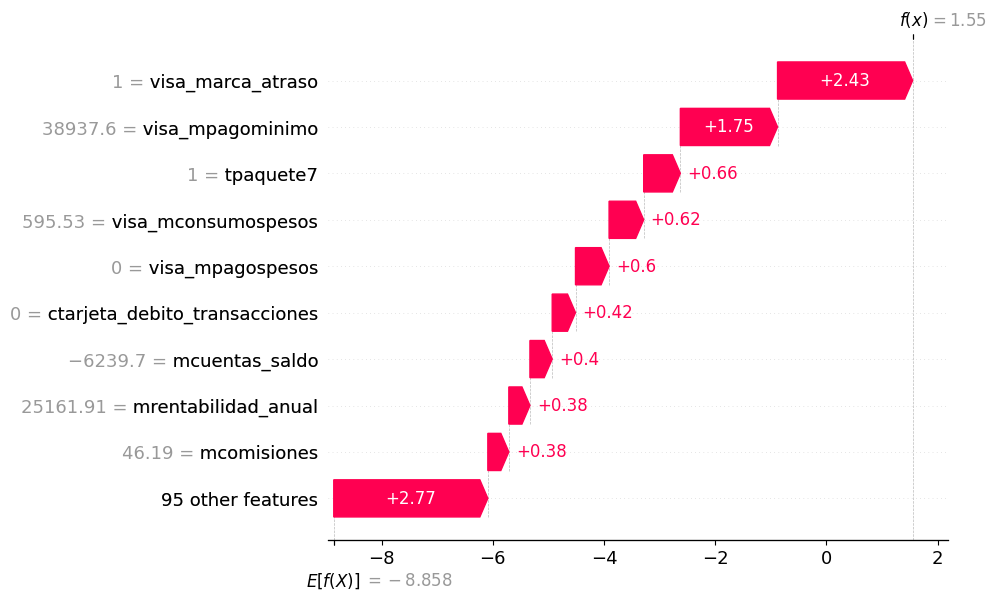

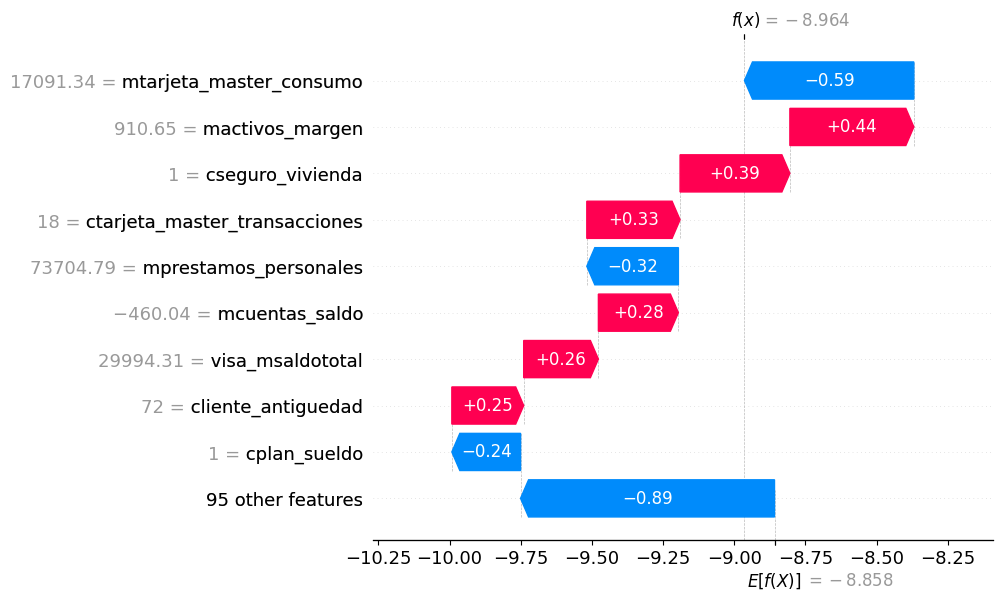

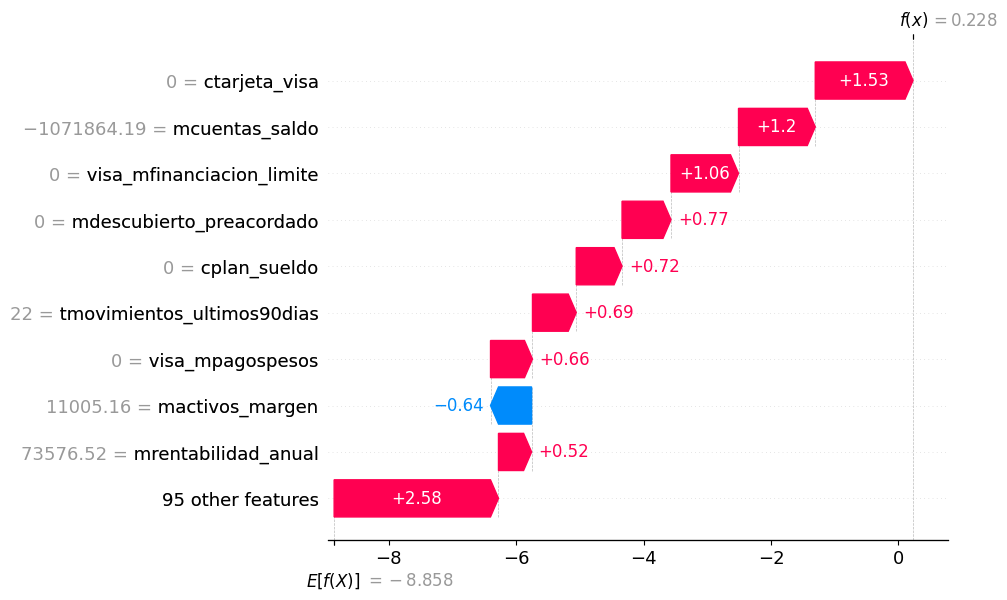

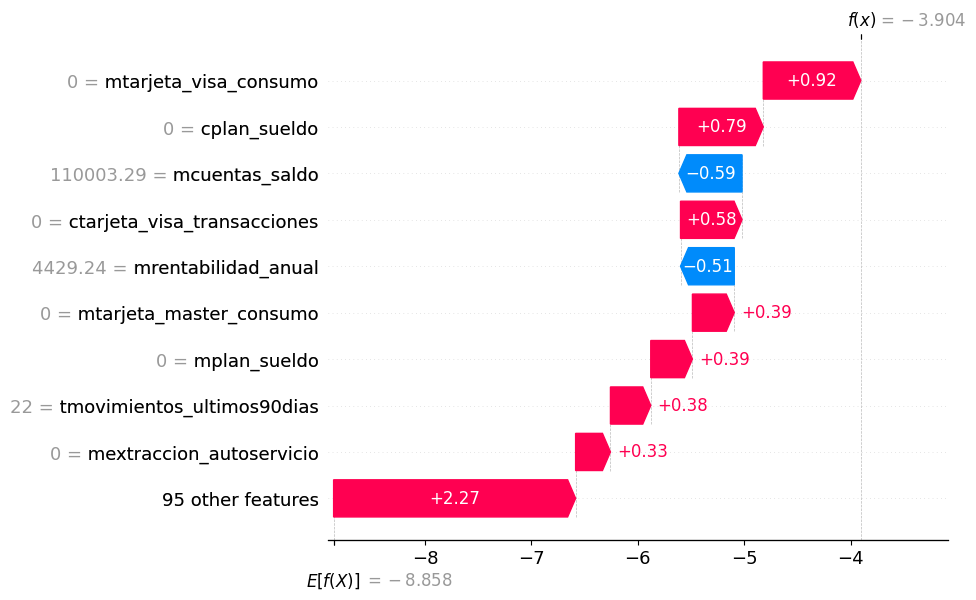

In [18]:
# Generate SHAP values for the entire dataset
shap_values = explainer(X)

# Plot waterfall plots for each case
shap.waterfall_plot(shap_values[tp_index], show=True, max_display=10)
shap.waterfall_plot(shap_values[tn_index], show=True, max_display=10)
shap.waterfall_plot(shap_values[fp_index], show=True, max_display=10)
shap.waterfall_plot(shap_values[fn_index], show=True, max_display=10)


In [61]:
import numpy as np

# Ensure y and y_pred are numpy arrays
y = np.array(y)
y_pred = np.array(y_pred)

# Identify indices of false negatives
false_negatives_indices = np.where((y == 1) & (y_pred == 0))[0]  # Actual = 1 (Churn), Predicted = 0 (No Churn)

# Select up to 10 false negatives
selected_fn_indices = false_negatives_indices[:10]

# Print the indices and corresponding data
print(f"False Negative Indices (up to 10): {selected_fn_indices}")
print("False Negatives Data:")
print(X.iloc[selected_fn_indices])  # Replace `X` with your features DataFrame
print("Actual Labels:", y[selected_fn_indices])
print("Predicted Labels:", y_pred[selected_fn_indices])


False Negative Indices (up to 10): [1320 2156 2400 3032 3639 3819 4692 4882 4903 5007]
False Negatives Data:
      cliente_vip  internet  cliente_edad  cliente_antiguedad  mrentabilidad  \
1320            0         1            50                 136         337.28   
2156            0         1            49                 255        1554.18   
2400            0         0            43                 162        1203.67   
3032            0         1            63                 259        1780.89   
3639            0         1            43                 175         832.92   
3819            0         0            63                 258       14639.66   
4692            0         1            57                 192        3234.68   
4882            0         0            71                 299        1601.02   
4903            0         0            45                  29         839.79   
5007            0         1            60                 299         423.43   

      mren

100%|===================| 164250/164621 [05:46<00:00]        

Waterfall plot for false negative at index: 1320


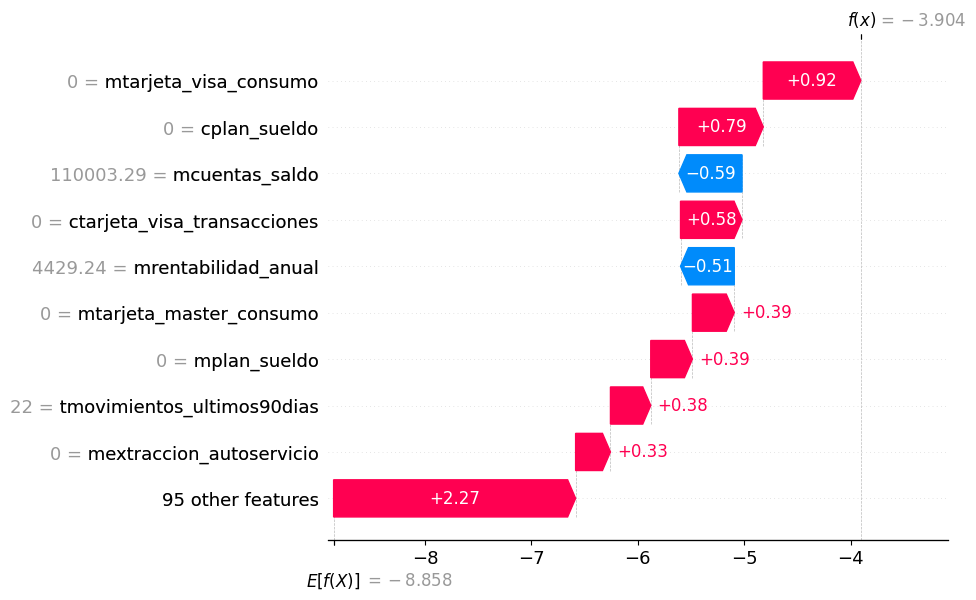

Waterfall plot for false negative at index: 2156


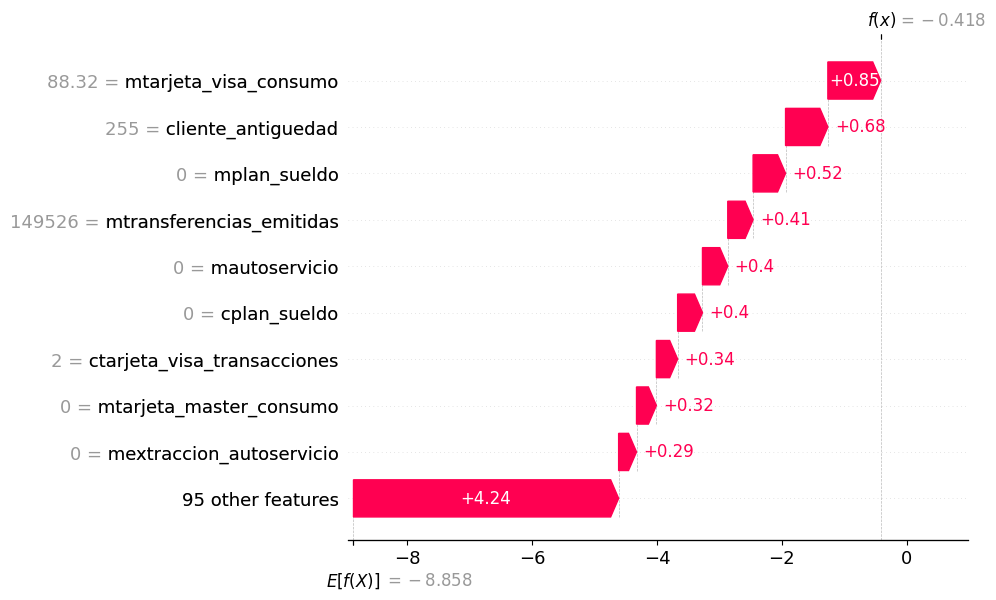

Waterfall plot for false negative at index: 2400


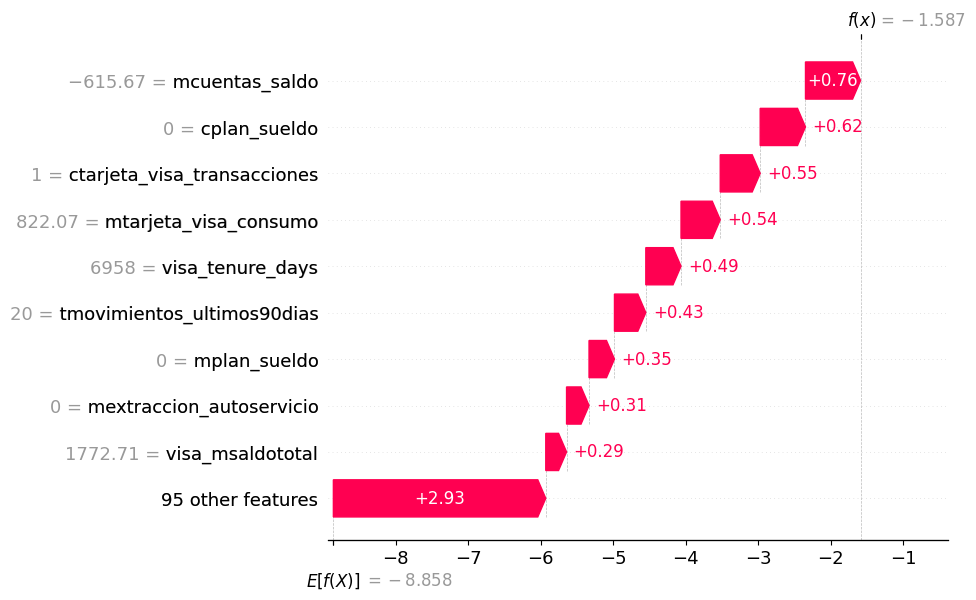

Waterfall plot for false negative at index: 3032


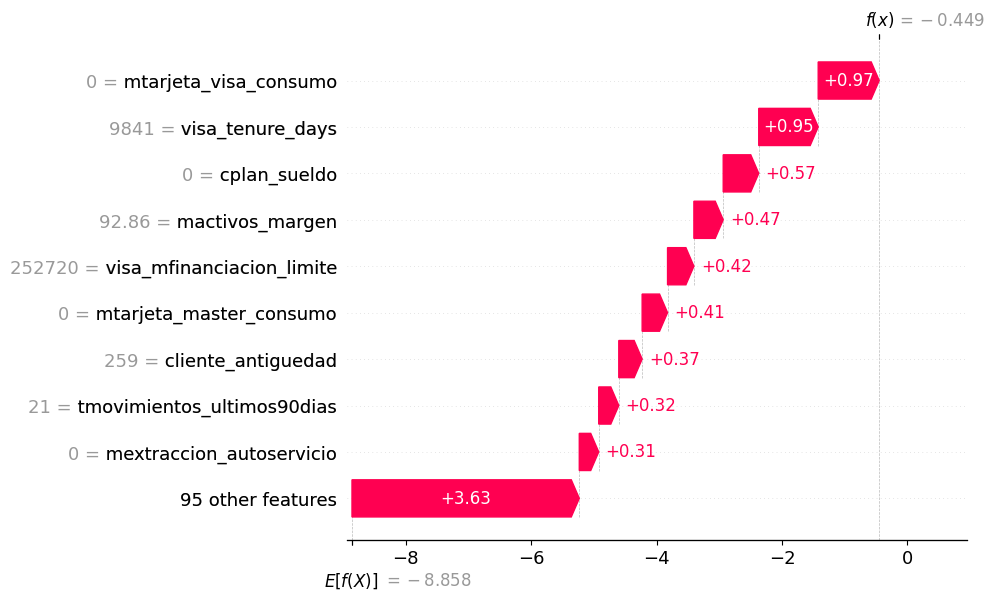

Waterfall plot for false negative at index: 3639


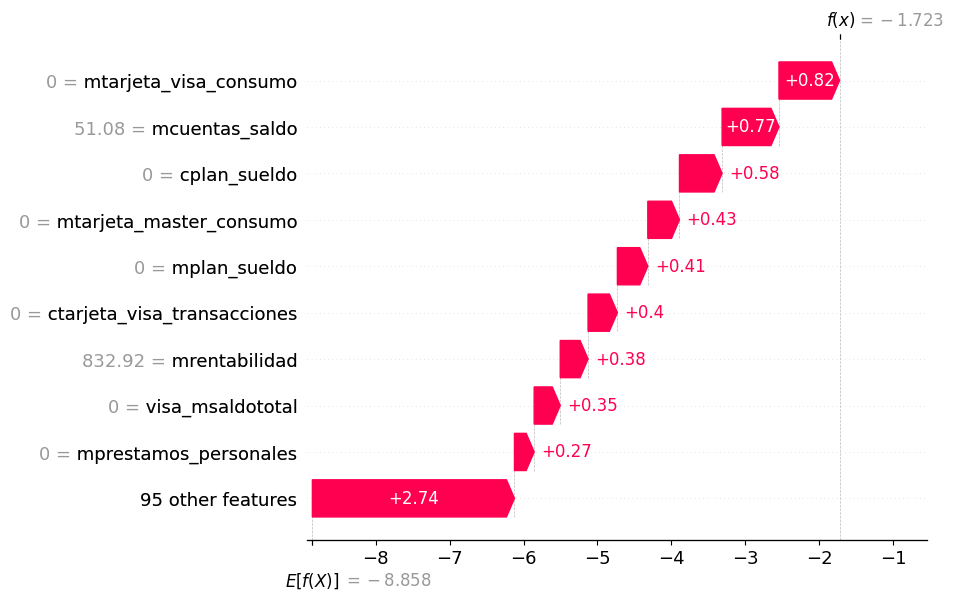

Waterfall plot for false negative at index: 3819


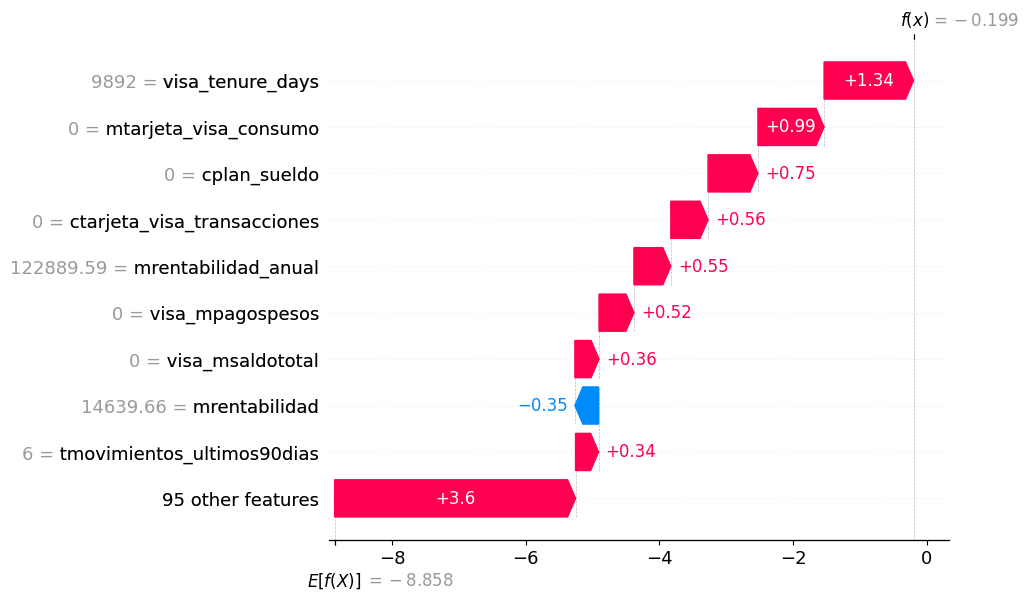

Waterfall plot for false negative at index: 4692


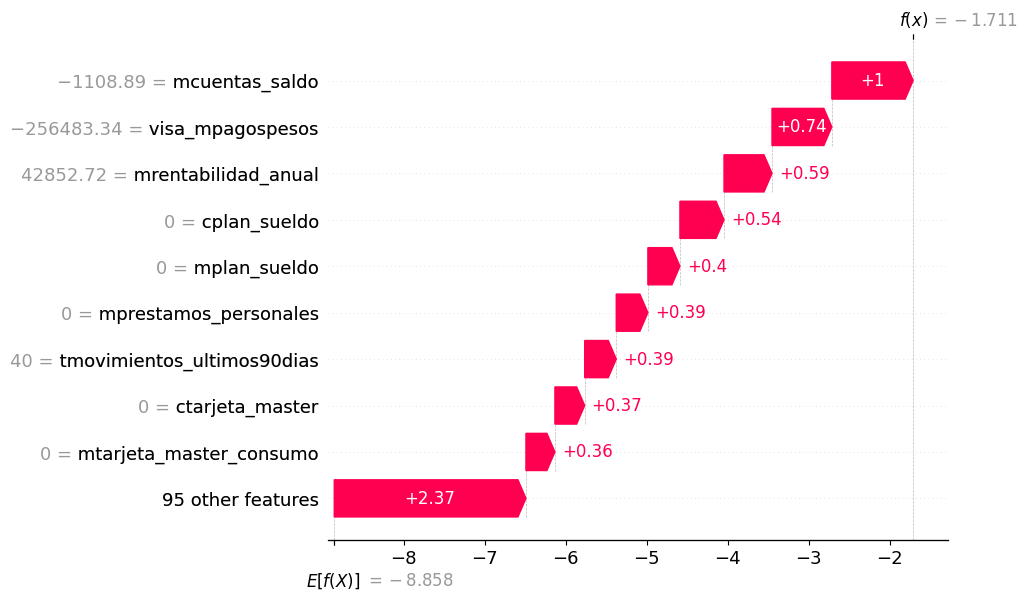

Waterfall plot for false negative at index: 4882


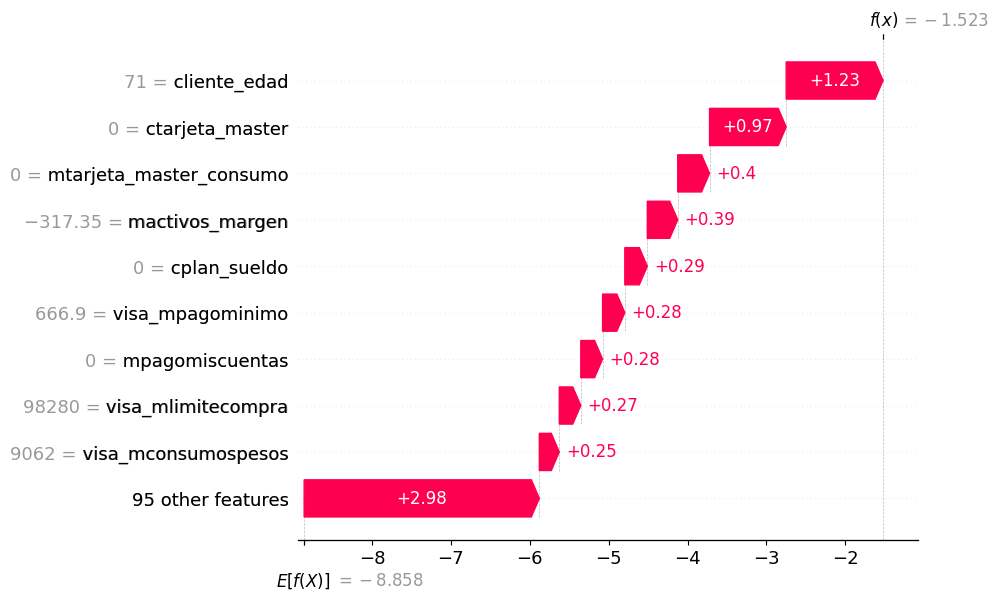

Waterfall plot for false negative at index: 4903


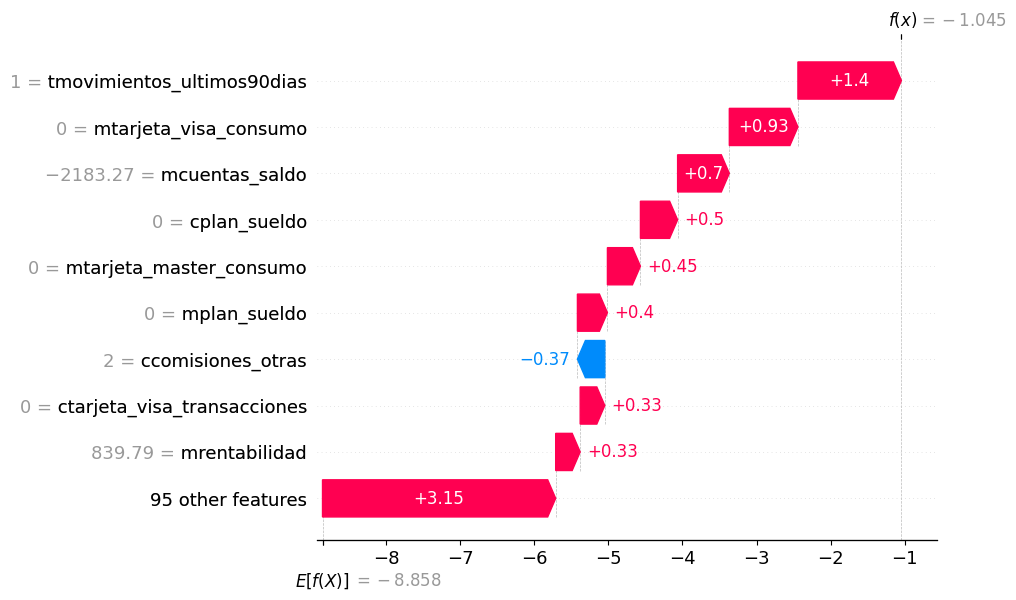

Waterfall plot for false negative at index: 5007


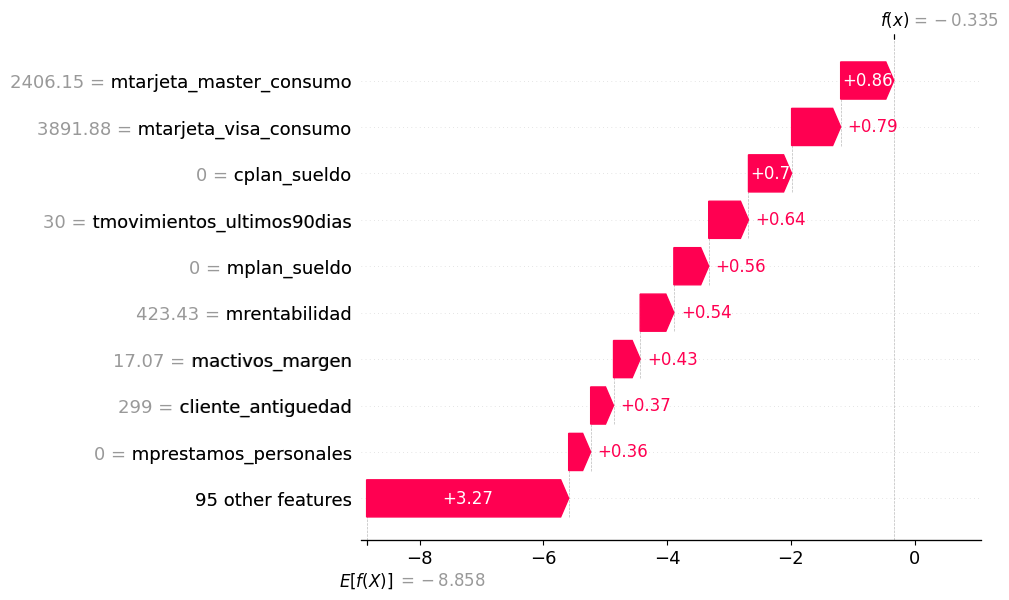

In [62]:
import shap

# Ensure you have the indices of false negatives
false_negatives_indices = np.where((y == 1) & (y_pred == 0))[0][:10]  # Adjust this if you already have `selected_fn_indices`

# Create the SHAP explainer for your trained model
explainer = shap.Explainer(xgb_model, X)  # Ensure `xgb_model` and `X` are defined
shap_values = explainer(X)  # Calculate SHAP values for the entire dataset

# Loop through each false negative and plot the waterfall
for idx in false_negatives_indices:
    print(f"Waterfall plot for false negative at index: {idx}")
    shap.waterfall_plot(shap_values[idx], max_display=10)  # Display top 10 features


# AdaBoost

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report

# Features and target
X = df.drop(columns=["clase_binaria"])  # Exclude the target column
y = df["clase_binaria"]

# Define a weak base learner for AdaBoost (e.g., a simple decision tree)
base_model = DecisionTreeClassifier(max_depth=1, random_state=12)  # Weak learner

# Define the AdaBoost model with the base learner
ada_model = AdaBoostClassifier(n_estimators=100, random_state=12)

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Perform stratified cross-validation with AUC scoring
cv_auc_scores = cross_val_score(ada_model, X, y, cv=skf, scoring='roc_auc')  # Using AUC as the metric

# Perform stratified cross-validation with Accuracy scoring
cv_accuracy_scores = cross_val_score(ada_model, X, y, cv=skf, scoring='accuracy')  # Using Accuracy as the metric

# Print Cross-Validation AUC Scores
print("Cross-Validation AUC Scores:", cv_auc_scores)

# Print Cross-Validation Accuracy Scores
print("Cross-Validation Accuracy Scores:", cv_accuracy_scores)

# Calculate and print the Mean AUC Score
print("Mean AUC Score:", cv_auc_scores.mean())

# Calculate and print the Mean Accuracy Score
print("Mean Accuracy Score:", cv_accuracy_scores.mean())

# Calculate and print the validation errors (1 - AUC score)
cv_auc_errors = 1 - cv_auc_scores
print("Validation Errors (AUC):", cv_auc_errors)
print("Mean Validation Error (AUC):", cv_auc_errors.mean())

# Calculate and print the validation errors (1 - accuracy score)
cv_accuracy_errors = 1 - cv_accuracy_scores
print("Validation Errors (Accuracy):", cv_accuracy_errors)
print("Mean Validation Error (Accuracy):", cv_accuracy_errors.mean())

# Fit the AdaBoost model on the entire dataset (optional, for evaluation purposes)
ada_model.fit(X, y)
y_pred = ada_model.predict(X)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["No Churn", "Churn"]))


/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciom

Cross-Validation AUC Scores: [0.93258528 0.9298826  0.91759524 0.9170523  0.92093953]
Cross-Validation Accuracy Scores: [0.99292331 0.99368242 0.99319645 0.99386466 0.99340906]
Mean AUC Score: 0.9236109891528628
Mean Accuracy Score: 0.9934151808813597
Validation Errors (AUC): [0.06741472 0.0701174  0.08240476 0.0829477  0.07906047]
Mean Validation Error (AUC): 0.0763890108471372
Validation Errors (Accuracy): [0.00707669 0.00631758 0.00680355 0.00613534 0.00659094]
Mean Validation Error (Accuracy): 0.0065848191186402396


/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

    No Churn       0.99      1.00      1.00    163292
       Churn       0.72      0.32      0.45      1329

    accuracy                           0.99    164621
   macro avg       0.86      0.66      0.72    164621
weighted avg       0.99      0.99      0.99    164621



/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciom

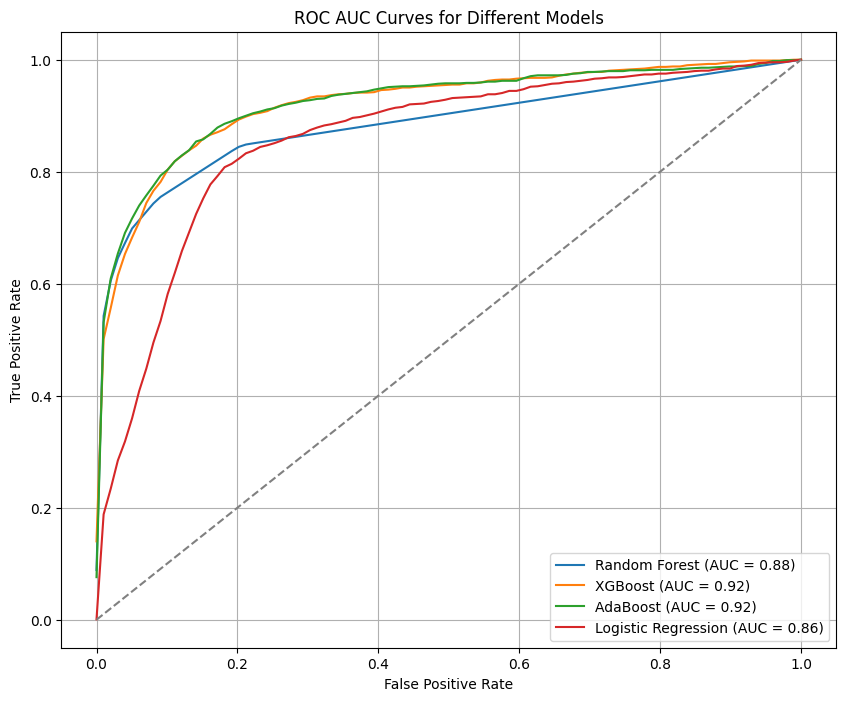

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Features and target
X = df.drop(columns=["clase_binaria"])  # Exclude the target column
y = df["clase_binaria"]

# Define models
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=12, n_estimators=100),
    "XGBoost": xgb.XGBClassifier(scale_pos_weight=100, random_state=12),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=12),
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=12, max_iter=1000)
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    # Initialize list for storing ROC curves
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # Cross-validation to get ROC curve for each fold
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Get probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
    
    # Compute mean TPR and AUC
    mean_tpr = np.mean(tprs, axis=0)
    roc_auc = auc(mean_fpr, mean_tpr)
    
    # Plot ROC curve
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
